In [1]:
### 4 Evaluation

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Dataset preparation

In [3]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df = df[['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']]

In [5]:
df.y = (df.y == 'yes').astype(int)
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [6]:
numerical = df.select_dtypes(include='number').columns.values
numerical

array(['age', 'balance', 'day', 'duration', 'campaign', 'pdays',
       'previous', 'y'], dtype=object)

In [7]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [8]:
categorical = ['job',
'marital',
'education',
'housing',
'contact',
'month',
'poutcome']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=len(df_test), random_state=1)

In [10]:
len(df_train), len(df_val), len(df_test)

(27125, 9043, 9043)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

### Question 1: ROC AUC feature importance

In [13]:
from sklearn.metrics import roc_auc_score

for num in numerical:
    auc = roc_auc_score(y_train, df_train[num])
    if auc < 0.5:
        auc = roc_auc_score(y_train, - df_train[num])
    print(f'{num}, {round(auc,3)}')

age, 0.512
balance, 0.589
day, 0.526
duration, 0.815
campaign, 0.571
pdays, 0.59
previous, 0.599


### Question 2: Training the model

In [14]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [16]:
val_dict = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [17]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [18]:
y_pred = model.predict_proba(X_val)[:, 1]
ras=roc_auc_score(y_val, y_pred).round(3)
ras

0.9

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8977109366360722

In [20]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.121
0.05 0.645
0.10 0.812
0.15 0.858
0.20 0.880
0.25 0.890
0.30 0.895
0.35 0.897
0.40 0.900
0.45 0.899
0.50 0.898
0.55 0.897
0.60 0.896
0.65 0.894
0.70 0.892
0.75 0.891
0.80 0.888
0.85 0.886
0.90 0.883
0.95 0.881
1.00 0.879


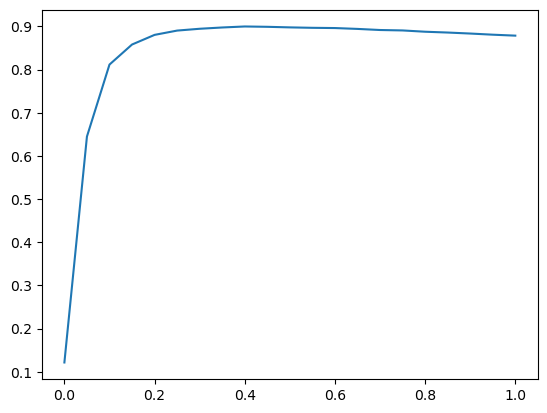

In [21]:
plt.plot(thresholds, scores)

In [22]:
from collections import Counter
print(Counter(y_pred >= 1.0))
print('mean: ',1 - y_val.mean())

Counter({False: 9043})
mean:  0.8785801172177374


In [23]:
### Confusion table

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)


t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)


tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()


confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[7755,  190],
       [ 735,  363]])

In [24]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.86, 0.02],
       [0.08, 0.04]])

### Question 3: Precision and Recall

In [25]:
thresholds = np.linspace(0, 1, 100)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()

    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()

    scores.append((t, tp, tn, fp, fn))

columns = ["threshold", "tp", "tn", "fp", "fn"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,tn,fp,fn
0,0.000000,1098,0,7945,0
10,0.101010,924,6431,1514,174
20,0.202020,706,7258,687,392
30,0.303030,554,7532,413,544
40,0.404040,449,7695,250,649
50,0.505051,360,7756,189,738
60,0.606061,287,7816,129,811
70,0.707071,214,7848,97,884
80,0.808081,141,7883,62,957
90,0.909091,68,7920,25,1030


In [26]:
df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores[::10]

,threshold,tp,tn,fp,fn,precision,recall
0,0.000000,1098,0,7945,0,0.121420,1.000000
10,0.101010,924,6431,1514,174,0.378999,0.841530
20,0.202020,706,7258,687,392,0.506820,0.642987
30,0.303030,554,7532,413,544,0.572906,0.504554
40,0.404040,449,7695,250,649,0.642346,0.408925
50,0.505051,360,7756,189,738,0.655738,0.327869
60,0.606061,287,7816,129,811,0.689904,0.261384
70,0.707071,214,7848,97,884,0.688103,0.194900
80,0.808081,141,7883,62,957,0.694581,0.128415
90,0.909091,68,7920,25,1030,0.731183,0.061931


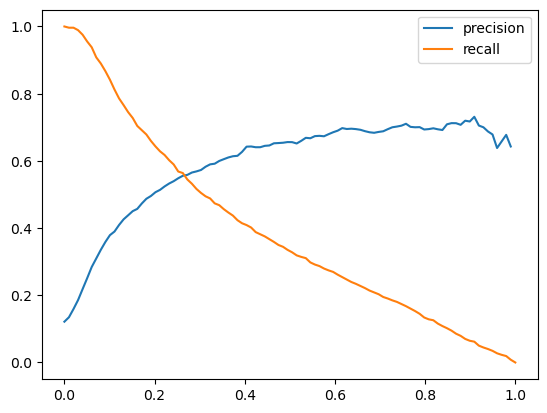

In [27]:
plt.plot(df_scores.threshold, df_scores.precision, label = "precision")
plt.plot(df_scores.threshold, df_scores.recall, label = "recall")

plt.legend()
plt.show()

### Question 4: F1 score

In [28]:
df_scores["f1_score"] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
# df_scores
df_scores[::10]


,threshold,tp,tn,fp,fn,precision,recall,f1_score
0,0.000000,1098,0,7945,0,0.121420,1.000000,0.216547
10,0.101010,924,6431,1514,174,0.378999,0.841530,0.522624
20,0.202020,706,7258,687,392,0.506820,0.642987,0.566841
30,0.303030,554,7532,413,544,0.572906,0.504554,0.536562
40,0.404040,449,7695,250,649,0.642346,0.408925,0.499722
50,0.505051,360,7756,189,738,0.655738,0.327869,0.437158
60,0.606061,287,7816,129,811,0.689904,0.261384,0.379128
70,0.707071,214,7848,97,884,0.688103,0.194900,0.303762
80,0.808081,141,7883,62,957,0.694581,0.128415,0.216756
90,0.909091,68,7920,25,1030,0.731183,0.061931,0.114190


In [29]:
df_scores.loc[df_scores["f1_score"] == df_scores["f1_score"].max()]

,threshold,tp,tn,fp,fn,precision,recall,f1_score
18,0.181818,745,7161,784,353,0.487247,0.678506,0.567187


### Question 5: 5-Fold CV

In [30]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=1):
    dicts = df_train[categorical + numerical].to_dict(orient = "records")

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = "records")

    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.y.values
    y_val = df_val.y.values
 
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(scores)
print('mean score:{}' 'std score:', np.mean(scores), np.std(scores))

[0.8997325107480013, 0.8989199463293431, 0.9112517872634994, 0.9081928839832232, 0.91217882418995]
mean score:{}std score: 0.9060551905028035 0.005656168836598589


### Question 6: Hyperparameter Tuning

In [32]:
n_splits = 5

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
     
        y_train = df_train.y.values
        y_val = df_val.y.values
     
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
     
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006


In [33]:
for C in [0.000001, 0.001, 1]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
     
        y_train = df_train.y.values
        y_val = df_val.y.values
     
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
     
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006


In [34]:
dv, model = train(df_full_train, df_full_train.y.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.9063538929896994